In [1]:
import dv_processing as dv
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_save_max_last_refact
from snn_delays.utils.visualization_utils import plot_conv_filters

device = get_device()
dataset = 'davis_loihi'
total_time = 250
batch_size = 64
folder_name = 'FromLoihi_ABCXO'

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to = 32,
                  folder_name = folder_name)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

Running on: cuda:0
[Downsample(time_factor=1, spatial_factor=1.0, sensor_size=None, target_size=None), ToFrame(sensor_size=(32, 32, 2), time_window=None, event_count=None, n_time_bins=250, n_event_bins=None, overlap=0, include_incomplete=False)]


In [2]:
dataset_dict['time_ms'] = 250
dataset_dict

{'num_input': 2048,
 'num_input_channels': 2,
 'num_training_samples': 3000,
 'num_output': 5,
 'dataset_name': 'davis_loihi',
 'time_ms': 250}

Delta t: 1.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 5, kernel_size=(2, 2), stride=(2, 2), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(5, 5, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=80, out_features=48, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=48, out_features=48, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=48, out_features=5, bias=False)
    )
  )
  (criterion): MSELoss()
)


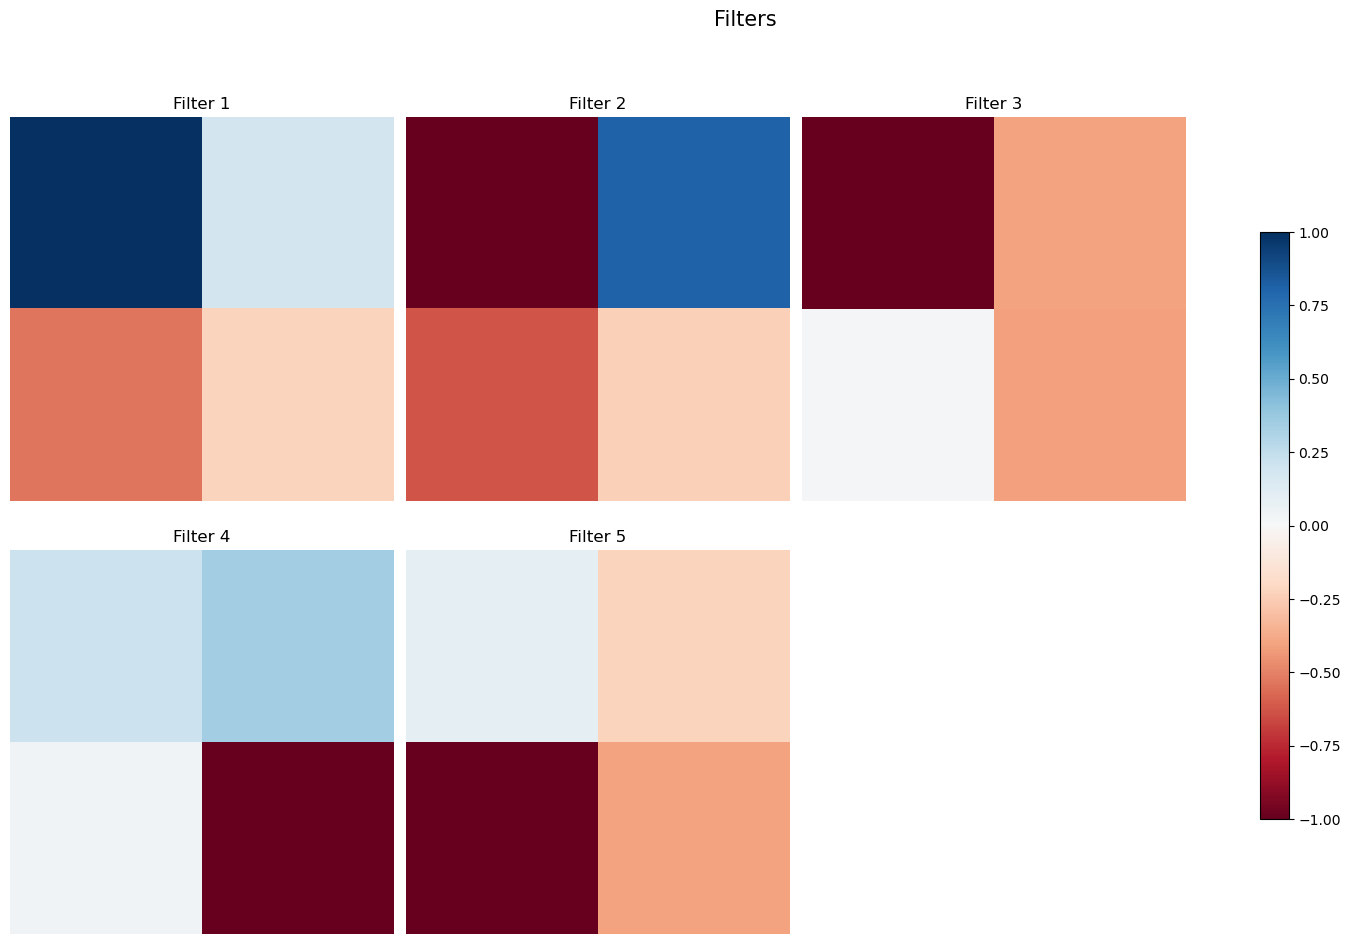

In [3]:
ckpt_dir = 'abcxo_32_Conv_15Hz'

# structure = (96, 2, 'f')

# extra_kwargs = {'conv':[(2, 16, 4), (16, 24, 4)]}

#extra_kwargs = {}

#tau_m = 50 # initial experiments
tau_m = 5.0 

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 5, 
        'kernel_size': 2 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 5, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 48 # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 48 # Number of neurons in this dense layer
    }
]


snn = SNN(dataset_dict=dataset_dict, model_config=model_config,
           tau_m=tau_m, win=total_time, loss_fn='spk_count', batch_size=batch_size, device=device, 
        )

#snn.input2spike_th = 0.5

snn.model_name = 'abcxo_conv_32_15Hz_5channel_v3'
snn.set_layers()
snn.to(device)
print(snn)

plot_conv_filters(snn.layers[0])

Epoch [1/10], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [15/46], Loss: 0.18529
Step [30/46], Loss: 0.16279
Step [45/46], Loss: 0.16204
Time elasped: 157.5633020401001
590
Test Loss: 0.16098313182592391
Avg spk_count per neuron for all 250 time-steps 1119.2528813559322
Test Accuracy of the model on the test samples: 21.186

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_32_Conv_15Hz
saving max acc: 21.1864406779661
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_32_Conv_15Hz
Epoch [2/10], learning_rates 0.001000, 0.100000
Step [15/46], Loss: 0.16000
Step [30/46], Loss: 0.15910
Step [45/46], Loss: 0.15761
Time elasped: 97.9578537940979
590
Test Loss: 0.1568553030490875
Avg spk_count per neuron for all 250 time-steps 1188.333220338983
Test Accuracy of the model on the test samples: 24.237

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_32_Conv_15Hz
saving max acc: 24.23728813559322
Model saved i

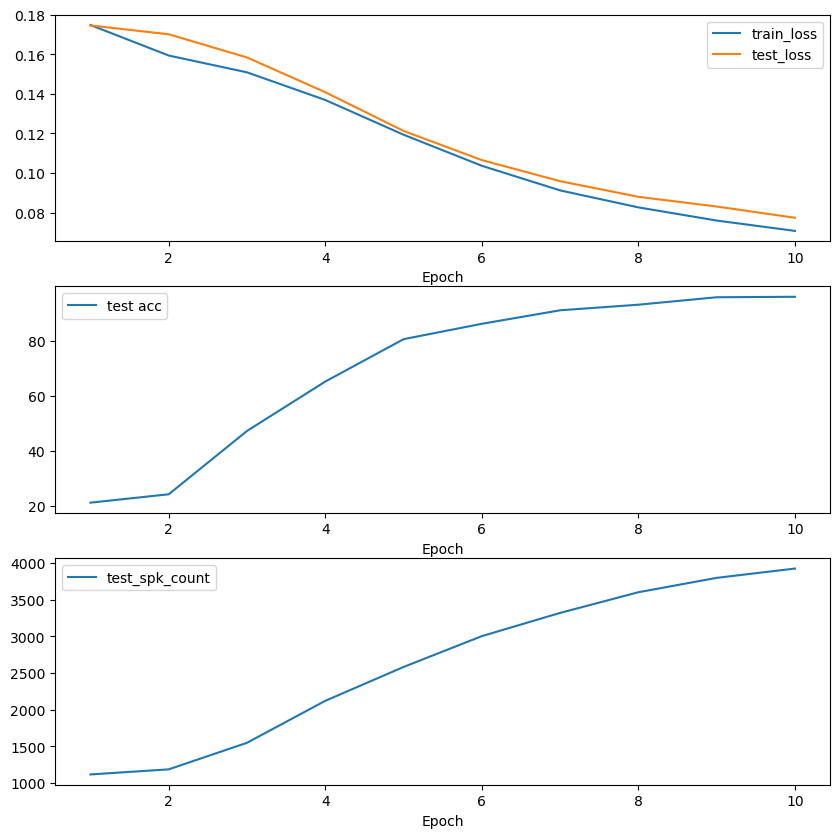

In [4]:
num_epochs = 10
lr = 1e-3
train(snn, train_loader, test_loader, lr, num_epochs, ckpt_dir=ckpt_dir,
       test_behavior=tb_save_max_last_refact, scheduler=(10, 0.95), test_every=1, freeze_taus=True)

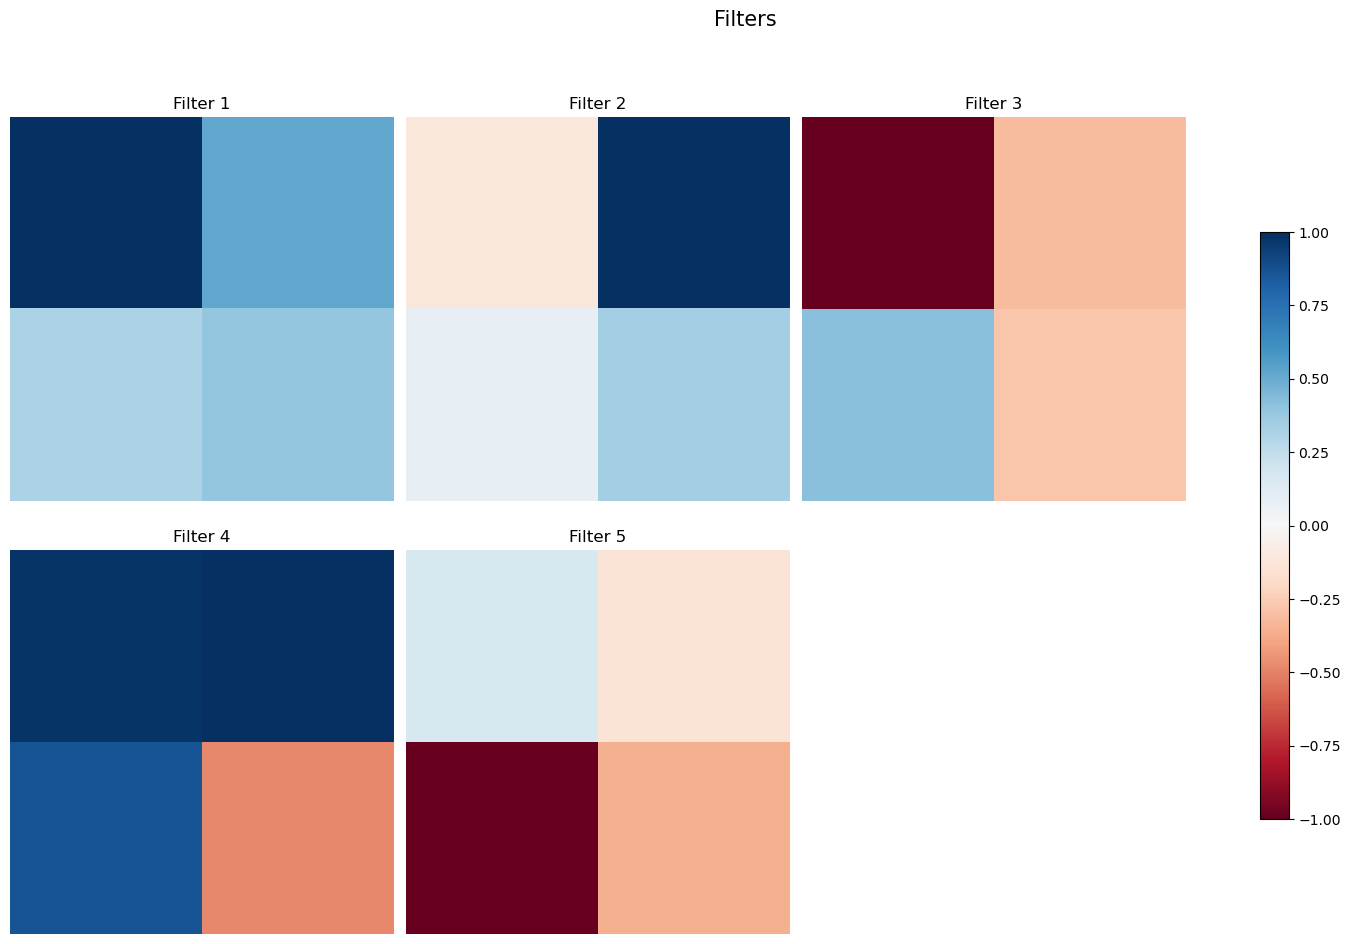

In [5]:
plot_conv_filters(snn.layers[0])